In [41]:
import pandas as pd

datafix = pd.read_csv('/Users/nshaffer/Desktop/hmm_model_datafix.csv')

In [42]:
import jumpdiff as jd

# Assuming your DataFrame is called datafix and has a 'close' column
close_series = datafix['Kalman'].values

# Estimate Kramers-Moyal coefficients (drift, diffusion, jump strength)
edges, moments = jd.moments(timeseries=close_series, correction=True)



In [43]:
import numpy as np
returns = np.diff(np.log(datafix['Close'].values))


run then jump model to only trade if high prob or upcoming chance of jumps 

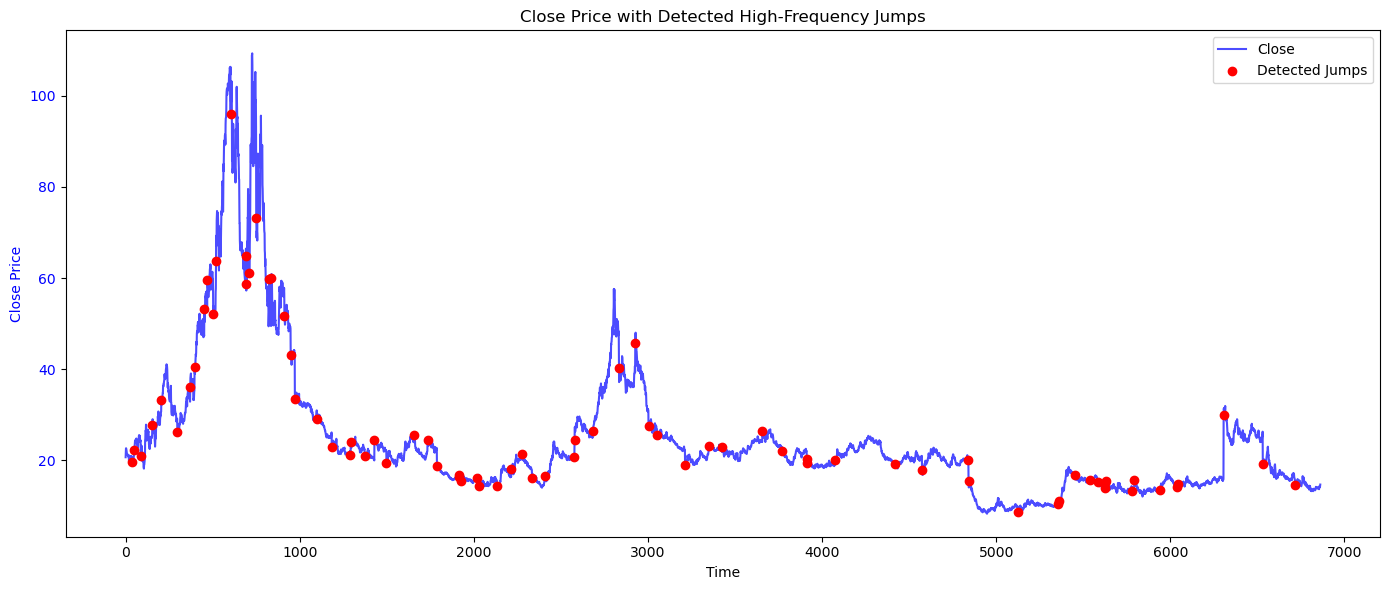

/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_81590/2725600987.py:68: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[False False False ... False False False]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  datafix.loc[datafix.index[window+1:], 'jump_flag'] = jumps[window:]


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute log returns
returns = np.diff(np.log(datafix['Close'].values))
abs_returns = np.abs(returns)

# Window size for local bipower variation (e.g., 20 minutes)
window = 50

# Bipower variation: BV_t = (pi/2) * sum_{i=2}^n |r_{i-1}| * |r_i| / (n-1)
BV = np.full(len(returns), np.nan)
for i in range(window, len(returns)):
    local_abs = abs_returns[i-window+1:i+1]
    BV[i] = (np.pi/2) * np.sum(local_abs[:-1] * local_abs[1:]) / (window-1)

# Jump test statistic: J_t = r_t^2 / BV_t
J = returns**2 / BV

# Threshold: flag as jump if J_t > threshold (e.g., 10)
threshold = 30
jumps = J > threshold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute log returns
returns = np.diff(np.log(datafix['Close'].values))
abs_returns = np.abs(returns)

# Window size for local bipower variation (e.g., 20 minutes)
window = 30

# Bipower variation: BV_t = (pi/2) * sum_{i=2}^n |r_{i-1}| * |r_i| / (n-1)
BV = np.full(len(returns), np.nan)
for i in range(window, len(returns)):
    local_abs = abs_returns[i-window+1:i+1]
    BV[i] = (np.pi/2) * np.sum(local_abs[:-1] * local_abs[1:]) / (window-1)

# Jump test statistic: J_t = r_t^2 / BV_t
J = returns**2 / BV

# Threshold: flag as jump if J_t > threshold (e.g., 10)
threshold = 15
jumps = J > threshold

# Plot close price and detected jumps
fig, ax1 = plt.subplots(figsize=(14,6))

# Plot close price
ax1.plot(datafix.index, datafix['Close'], label='Close', color='blue', alpha=0.7)
ax1.set_xlabel('Time')
ax1.set_ylabel('Close Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Overlay detected jumps as red dots
jump_indices = np.where(jumps)[0] + 1  # +1 to align with close price index
ax1.scatter(datafix.index[jump_indices], datafix['Close'].values[jump_indices], 
            color='red', label='Detected Jumps', zorder=5)

plt.title('Close Price with Detected High-Frequency Jumps')
plt.legend()
plt.tight_layout()
plt.show()

datafix['jump_flag'] = np.nan
datafix.loc[datafix.index[window+1:], 'jump_flag'] = jumps[window:]


In [45]:
datafix.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Kalman', 'Kalman_Roc',
       'MACD', 'Signal', 'MACD_Hist', 'days_to_expiry', 'stock price',
       'strike', 'rfr', 'type', 'IV', 'IVROC', 'delta', 'gamma', 'vega',
       'theta', 'MACD_Hist_std', 'IV_garch_vol', 'GarchRoc', 'GarchRoc5sma',
       'GarchSma', 'GarchSmaSpread', 'GarchSmaSpread_std', 'GarchRocsma_std',
       'GarchRoc_std', 'RSI', 'rsiMA_14', 'MACDvol', 'Signalvol',
       'MACD_Histvol', 'MACDROCvol', 'MACDkalman', 'Signalkalman',
       'MACD_Histkalman', 'MACDROCkal', 'MACDROC', 'VolumeSMA9', 'VolumeSMA26',
       'Kalman_Roc_roll', 'MACDROCvolroll9', 'MACDROCkalroll9', 'stocktrend',
       'sma30', 'smaspread', 'IV_garch_volsma', 'kalmansma', 'log_return',
       'hmm_state', 'entropy', 'BuyLabel', 'SellLabel', 'VolumeSMA3',
       'forecasted_hmm_state', 'Predicted_Signal', 'Predicted_Sell',
       'Buy_Prob', 'Sell_Prob', 'Combined_Score', 'Combined_Signal',
       'Signal_Num', 'Rolling_Signal_Num', 'Trade_Sign

In [46]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report

# 1. Define target variable (ensure jump_flag is 0/1, and drop NaNs)
datafix = datafix.copy()
datafix['jump_flag'] = datafix['jump_flag'].astype(float)
datafix = datafix.dropna(subset=['jump_flag'])

# 2. Prepare features (drop target and any non-feature columns)
feature_cols = [col for col in datafix.columns if col not in ['jump_flag', 'prob_next_jump','open','high','low','hmm_state','BuyLabel','SellLabel']]
X = datafix[feature_cols].select_dtypes(include=[np.number])

# ---- SHIFT FEATURES BACK BY 3 ----
X_shifted = X.shift(10)

# Align target with shifted features
y = datafix['jump_flag']

# Combine and drop any rows with NaNs (due to shifting)
df_model = pd.concat([X_shifted, y], axis=1).dropna()
X_final = df_model[X_shifted.columns]
y_final = df_model['jump_flag']

# 3. Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, stratify=y_final, random_state=42)

# 4. Fit Gradient Boosting Classifier
gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbm.fit(X_train, y_train)

# 5. Predict probabilities and evaluate
y_pred_proba = gbm.predict_proba(X_test)[:, 1]
print("AUC:", roc_auc_score(y_test, y_pred_proba))
print(classification_report(y_test, gbm.predict(X_test)))

# 6. Add predicted jump probabilities to your DataFrame (align indices)
datafix.loc[X_test.index, 'jump_prob_gbm'] = y_pred_proba


AUC: 0.5933579652861316
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99      2024
         1.0       0.00      0.00      0.00        23

    accuracy                           0.98      2047
   macro avg       0.49      0.50      0.49      2047
weighted avg       0.98      0.98      0.98      2047



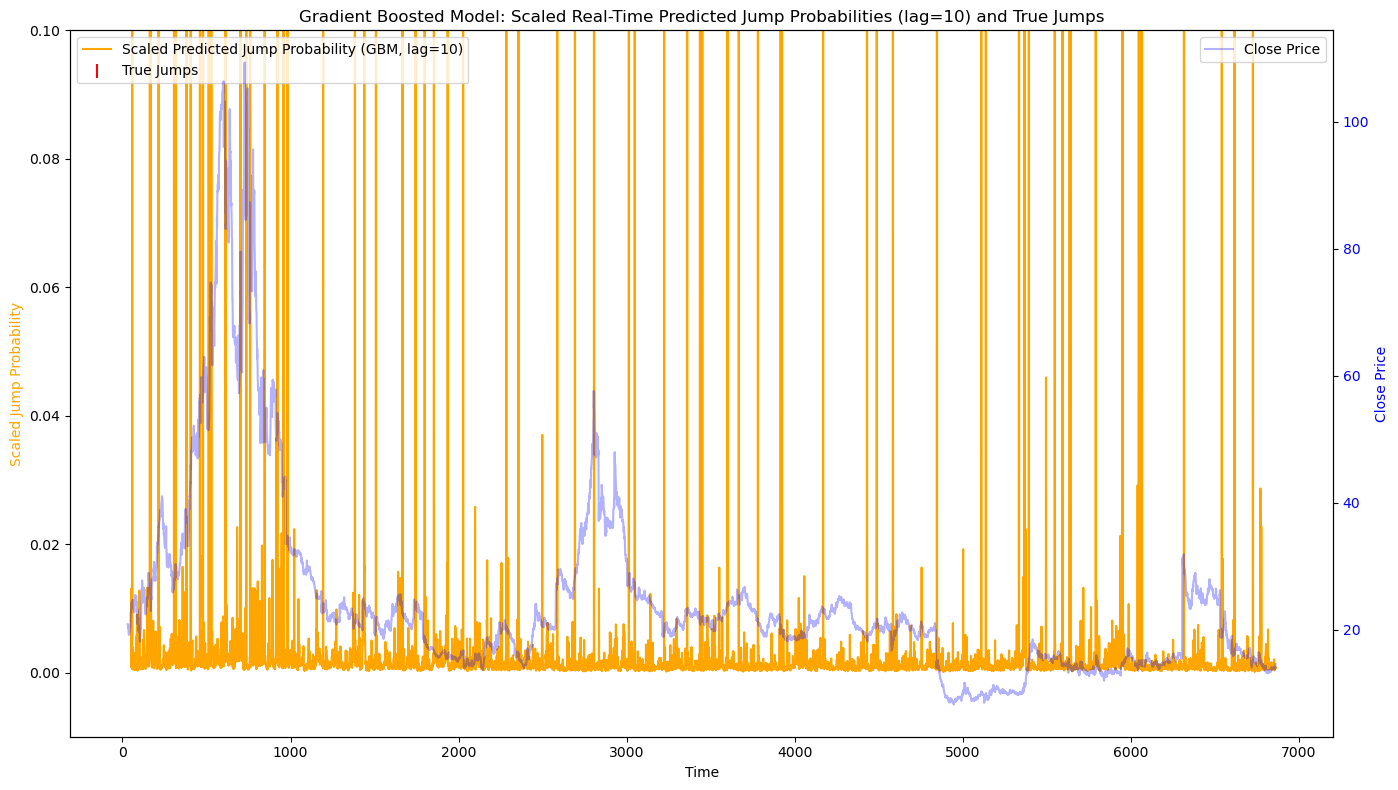

In [59]:
lag = 10  # or whatever lag you used in .shift()

# After fitting your model and getting jump_probs:
jump_probs = gbm.predict_proba(X_final)[:, 1]

# Create a Series aligned to X_final's index
prob_series = pd.Series(jump_probs, index=X_final.index)

# Shift the probabilities backward by the lag so they appear at the time the prediction would have been made
prob_series_real_time = prob_series.shift(lag)

# Scale the probabilities so the maximum is 1
prob_series_real_time_scaled = prob_series_real_time / prob_series_real_time.max()

# Add to your DataFrame for plotting
datafix['jump_prob_gbm_real_time'] = prob_series_real_time_scaled

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot scaled, real-time predicted jump probabilities (with lag)
plt.plot(datafix.index, datafix['jump_prob_gbm_real_time'], 
         label=f'Scaled Predicted Jump Probability (GBM, lag={lag})', color='orange')

# Plot true jump events as vertical lines
plt.scatter(
    datafix.index[datafix['jump_flag'] == 1],
    [1.05]*int(datafix['jump_flag'].sum()),
    color='red', marker='|', s=100, label='True Jumps'
)

# Plot close price (secondary y-axis)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(datafix.index, datafix['Close'], 
         label='Close Price', color='blue', alpha=0.3)
ax2.set_ylabel('Close Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Formatting
ax1.set_ylabel('Scaled Jump Probability', color='orange')
ax1.set_xlabel('Time')
ax1.set_ylim(-0.05, 1.1)
plt.title(f'Gradient Boosted Model: Scaled Real-Time Predicted Jump Probabilities (lag={lag}) and True Jumps')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.tight_layout()
ax1.set_ylim(-0.01, 0.10)

plt.show()


In [49]:
neighbors = 10 
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- Local extrema detection (as labels, not features) ---
series = datafix['Kalman'].values
order = neighbors  # Adjust for sensitivity

max_idx = argrelextrema(series, np.greater, order=order)[0]
min_idx = argrelextrema(series, np.less, order=order)[0]

datafix['BuyLabel'] = 0
datafix['SellLabel'] = 0
datafix.iloc[min_idx, datafix.columns.get_loc('BuyLabel')] = 1
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Feature engineering ---
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# --- Forecasted regime feature ---
# Assume you have already fit an HMM called `model` and assigned 'hmm_state' column
# model.transmat_ is the transition matrix, datafix['hmm_state'] is the current regime

def forecast_next_regime(states, transmat):
    # Returns the most probable next regime for each row based on the current regime
    return [np.argmax(transmat[state]) if not np.isnan(state) else np.nan for state in states]



# --- Define features (add forecasted regime) ---
features = [
    "kalmansma",
    "IV_garch_vol",
    "VolumeSMA9",
    "Close",
    "stock price", 
    "MACD_Hist",
    "Kalman_Roc",
    "delta",
    "gamma",
    "vega",
    "theta",
    "forecasted_hmm_state",
    "Volume", 
    "RSI","jump_prob_gbm_real_time",
]

# Drop rows with missing values in features or label for training
model_data = datafix.dropna(subset=features + ["BuyLabel"])

# Prepare a column for storing predictions
model_data["Predicted_Signal"] = np.nan

# Use the forecasted regime as a feature for the whole dataset (no regime split)
X = model_data[features]
y = model_data["BuyLabel"]

# 70/30 split, no shuffle to preserve time order
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
hgb = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)

hgb.fit(X_train, y_train)

# Predict for the entire dataset
model_data["Predicted_Signal"] = hgb.predict(X)

# Optionally, print classification report for test set
y_pred_test = hgb.predict(X_test)
print("\nClassification report (using forecasted regime as feature):")
print(classification_report(y_test, y_pred_test))

# Merge predictions back into your main datafix DataFrame
datafix["Predicted_Signal"] = model_data["Predicted_Signal"]


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_81590/4167047344.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["Predicted_Signal"] = np.nan



Classification report (using forecasted regime as feature):
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1991
           1       0.11      0.72      0.19        53

    accuracy                           0.84      2044
   macro avg       0.55      0.78      0.55      2044
weighted avg       0.97      0.84      0.89      2044



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_81590/4167047344.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["Predicted_Signal"] = hgb.predict(X)


In [51]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import classification_report

# --- Local maxima detection for SellLabel ---
order = neighbors  # Sensitivity parameter
series = datafix['Kalman'].values
max_idx = argrelextrema(series, np.greater, order=order)[0]

datafix['SellLabel'] = 0
datafix.iloc[max_idx, datafix.columns.get_loc('SellLabel')] = 1

# --- Feature engineering ---
datafix["VolumeSMA3"] = datafix["Volume"].rolling(3).mean()
datafix["VolumeSMA9"] = datafix["Volume"].rolling(9).mean()
datafix["VolumeSMA26"] = datafix["Volume"].rolling(26).mean()

# --- Forecasted regime feature ---
# Assume you have already fit an HMM called `model` and assigned 'hmm_state' column
def forecast_next_regime(states, transmat):
    # Returns the most probable next regime for each row based on the current regime
    return [np.argmax(transmat[state]) if not np.isnan(state) else np.nan for state in states]





# Drop rows with missing values in features or SellLabel for training
model_data = datafix.dropna(subset=features + ["SellLabel"])

# Prepare a column to store predictions
model_data["Predicted_Sell"] = np.nan

# Use the forecasted regime as a feature for the whole dataset (no regime split)
X = model_data[features]
y = model_data["SellLabel"]

# 70/30 split, no shuffle to preserve time order
split_idx = int(len(X) * 0.7)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Train model
hgb_sell = HistGradientBoostingClassifier(
    max_iter=1000,
    learning_rate=0.05,
    max_depth=3,
    random_state=42,
    class_weight='balanced',
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10
)
hgb_sell.fit(X_train, y_train)

# Predict for the entire dataset
model_data["Predicted_Sell"] = hgb_sell.predict(X)

# Optionally, print classification report for test set
y_pred_test = hgb_sell.predict(X_test)
print("\nClassification report (using forecasted regime as feature):")
print(classification_report(y_test, y_pred_test))

# Merge predictions back into your main datafix DataFrame
datafix["Predicted_Sell"] = model_data["Predicted_Sell"]


/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_81590/1080205351.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["Predicted_Sell"] = np.nan



Classification report (using forecasted regime as feature):
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1992
           1       0.18      0.31      0.22        52

    accuracy                           0.95      2044
   macro avg       0.58      0.64      0.60      2044
weighted avg       0.96      0.95      0.95      2044



/var/folders/f_/1bh6mfq97bxdwzwnr49jf8nm0000gn/T/ipykernel_81590/1080205351.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["Predicted_Sell"] = hgb_sell.predict(X)


In [53]:
# Get probabilities (assuming binary classification, class 1 is buy/sell)
datafix["Buy_Prob"] = hgb.predict_proba(datafix[features])[:, 1]
datafix["Sell_Prob"] = hgb_sell.predict_proba(datafix[features])[:, 1]

# Weighted difference (you can adjust the weights)
datafix["Combined_Score"] = datafix["Buy_Prob"] - datafix["Sell_Prob"]
buy_thresh = .3
sell_thresh = -.3
# Define thresholds for action
def weighted_signal(score, buy_thresh=buy_thresh, sell_thresh=sell_thresh):
    if score > buy_thresh:
        return "buy"
    elif score < sell_thresh:
        return "sell"
    else:
        return "hold"

datafix["Combined_Signal"] = datafix["Combined_Score"].apply(weighted_signal)


Total Return (Last 30%): -58.75%


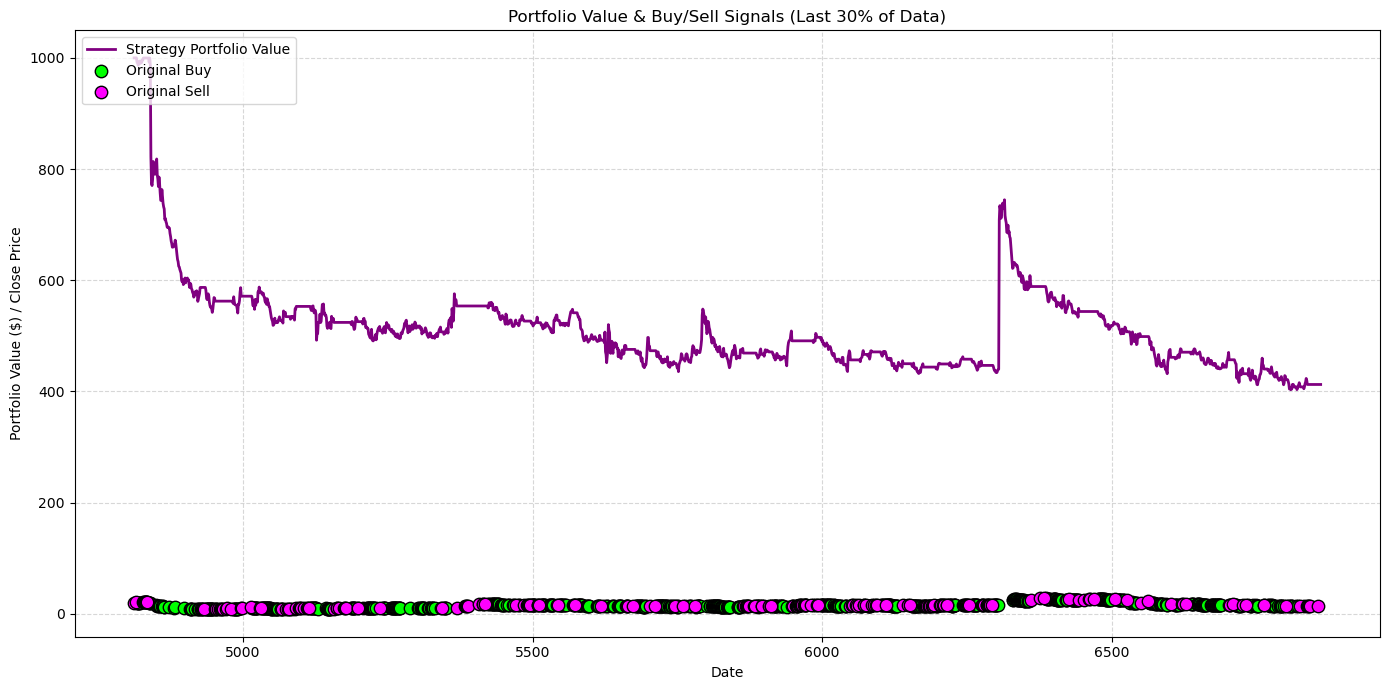


Selected columns from the last 30% of data:
      Close  Combined_Score Combined_Signal
6852  13.85        0.519239            hold
6853  14.00        0.330871            sell
6854  13.63        0.511291            hold
6855  14.19        0.365031            hold
6856  14.27        0.303897            sell
6857  14.16        0.337342            hold
6858  14.30        0.332509            hold
6859  14.05        0.513385            hold
6860  14.41        0.268833            sell
6861  14.65        0.413028            hold


Number of trades: 52
Total fees paid: $397.82
Win rate (profitable trades): 55.77%
Average allocation per trade: 0.75
Total return: -59.12%
Average return per trade: 0.17%
Average holding period: 0.00 days
Sharpe ratio: 0.02
Standard deviation: 0.0816
Maximum drawdown: -59.57%
